In [1]:
import torch 
import torch.nn as nn

from skimage import io
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

In [2]:
im_path = "/kaggle/input/image-net-visualization/baby_elephant.png"
image_size = 1024

In [3]:
def get_image(im_path,shape=image_size):
    img = io.imread(im_path)[:,:,:3]
    org_img = img.copy()
    img = A.Normalize()(image=img)["image"]
    norm_img = img.copy()
    img = np.transpose(img,(2,0,1))
    img = np.expand_dims(img,0)

    img = torch.tensor(img)
    img = nn.Upsample((shape,shape))(img)
    
    return img,norm_img, org_img

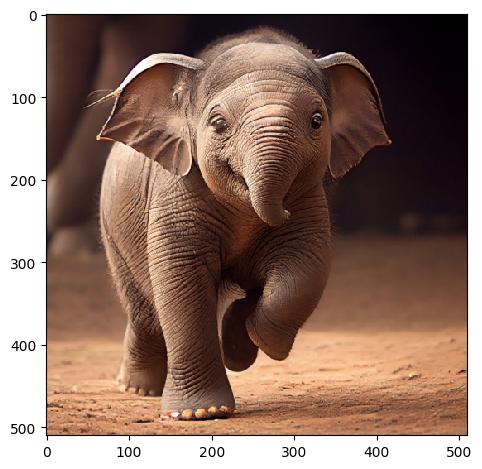

In [4]:
img,norm_img, org_img = get_image(im_path)
io.imshow(org_img)

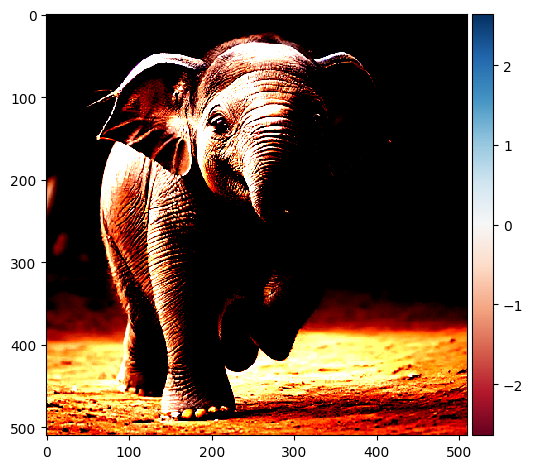

In [5]:
io.imshow(norm_img)

In [6]:
from transformers import ViTModel, ViTConfig

config = ViTConfig.from_pretrained("google/vit-base-patch16-384")
config.image_size = image_size

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

In [7]:
model = ViTModel.from_pretrained("google/vit-base-patch16-384",config=config,ignore_mismatched_sizes=True).cuda()

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized because the shapes did not match:
- vit.embeddings.position_embeddings: found shape torch.Size([1, 577, 768]) in the checkpoint and torch.Size([1, 4097, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
output = model(pixel_values=img.cuda(),
               output_attentions=True,
               output_hidden_states=True,
               interpolate_pos_encoding=True,
               return_dict=True,)

In [9]:
output.keys()
print(
"\n last_hidden_state", output["last_hidden_state"].shape, 
"\n pooler_output", output["pooler_output"].shape, 
"\n attentions last layer", output["attentions"][-1].shape, 
)


 last_hidden_state torch.Size([1, 4097, 768]) 
 pooler_output torch.Size([1, 768]) 
 attentions last layer torch.Size([1, 12, 4097, 4097])


## Visualizing Feature Vector Outputs patchwise based on mean

In [10]:
feature = output["last_hidden_state"] ## 1xnum_patches+1x768

In [11]:
feature_map = feature.mean(axis=-1) ## taking mean at feature axis ## [num_patches+1x]
feature_map = feature_map[:,1:] ## removing cls token ## [1,num_patches]
map_size = int(np.sqrt(4096))

feature_map = feature_map.view(1,1,map_size,map_size) ## adding channel axis for upsample

feature_map = nn.Upsample(size=(1024,1024))(feature_map)
print(feature_map.shape)

torch.Size([1, 1, 1024, 1024])


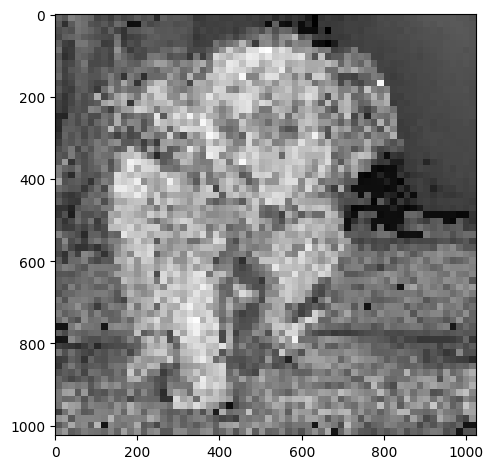

In [12]:
feature_map = feature_map[0,0,:,:].detach().cpu().numpy()

feature_map = (feature_map-feature_map.min())/(feature_map.max()-feature_map.min())
io.imshow(feature_map)

## Visualizing Attentions Vector Outputs patchwise based on mean

In [13]:
attentions = output["attentions"][-1] ## 1xnum_patches+1x768
print(attentions.shape)

torch.Size([1, 12, 4097, 4097])


torch.Size([1, 1, 1024, 1024])


/opt/conda/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


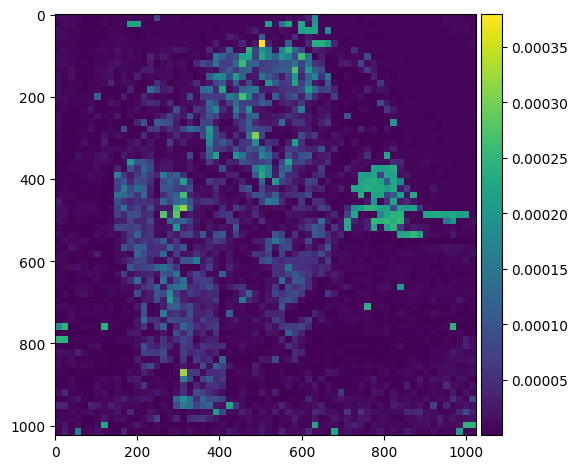

torch.Size([1, 1, 1024, 1024])


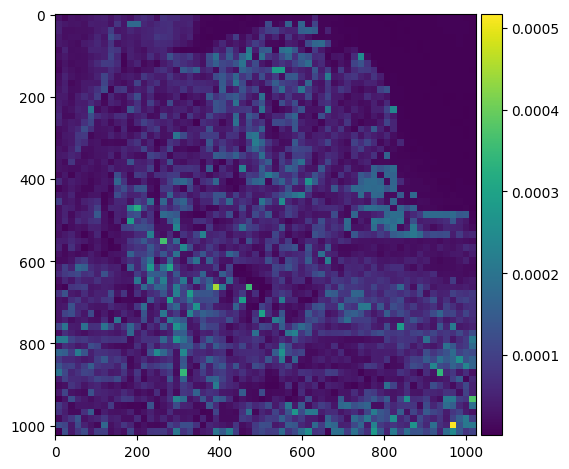

torch.Size([1, 1, 1024, 1024])


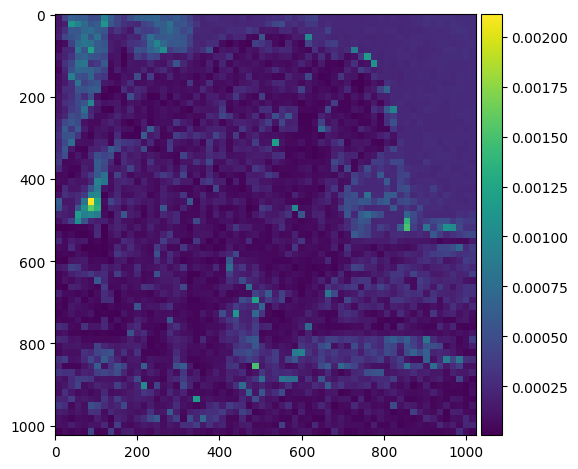

torch.Size([1, 1, 1024, 1024])


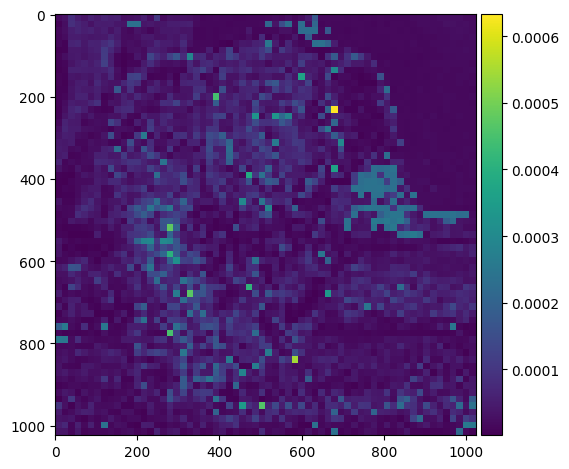

torch.Size([1, 1, 1024, 1024])


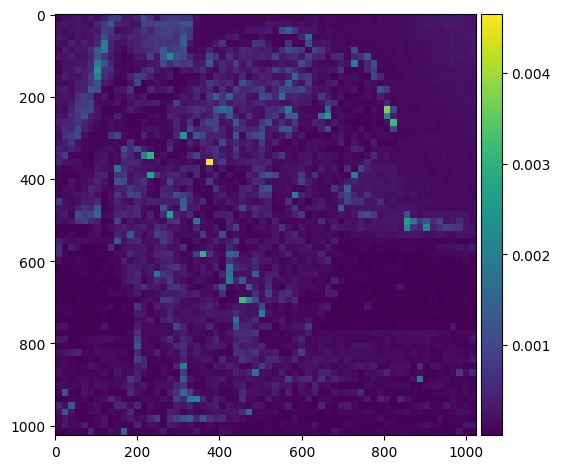

torch.Size([1, 1, 1024, 1024])


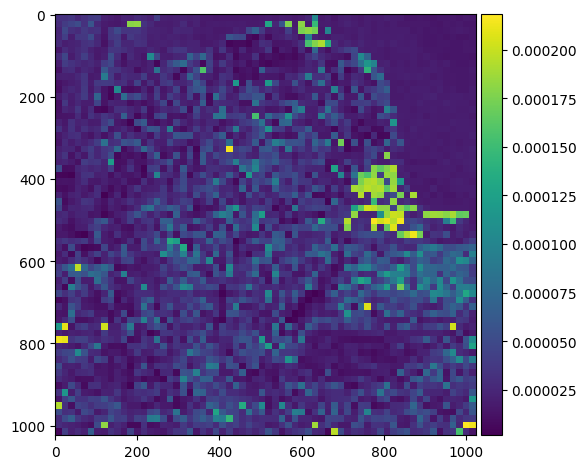

torch.Size([1, 1, 1024, 1024])


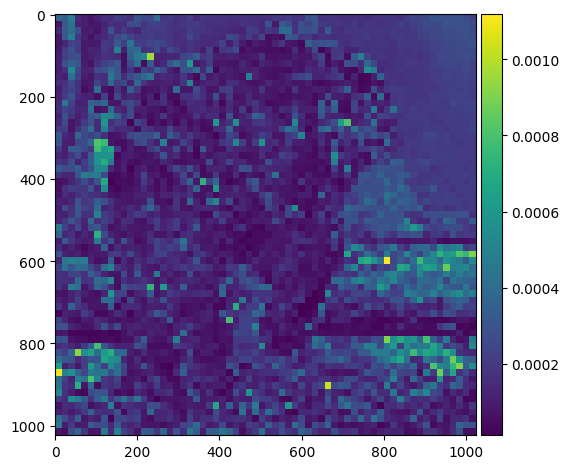

torch.Size([1, 1, 1024, 1024])


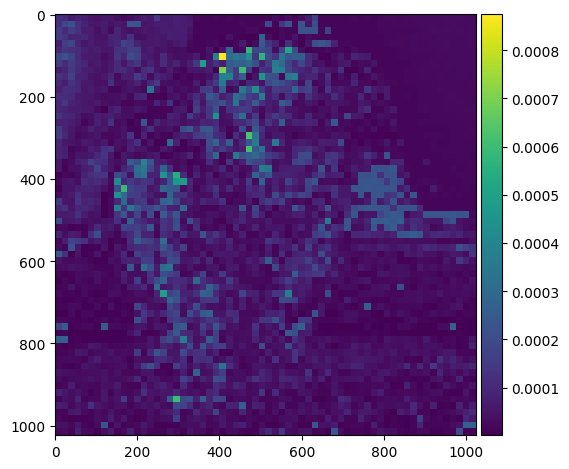

torch.Size([1, 1, 1024, 1024])


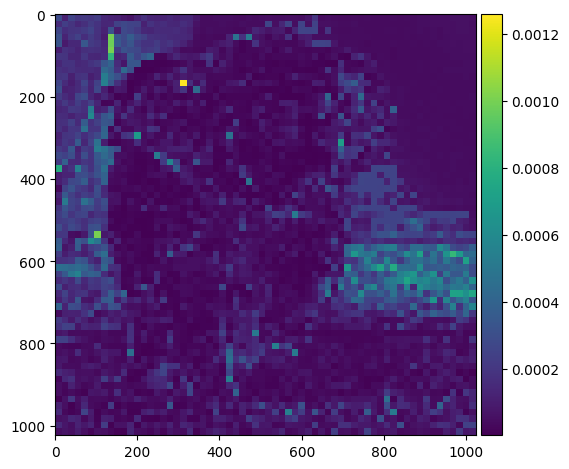

torch.Size([1, 1, 1024, 1024])


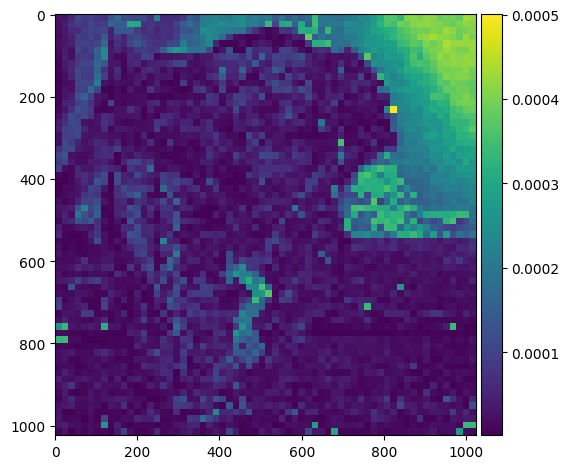

torch.Size([1, 1, 1024, 1024])


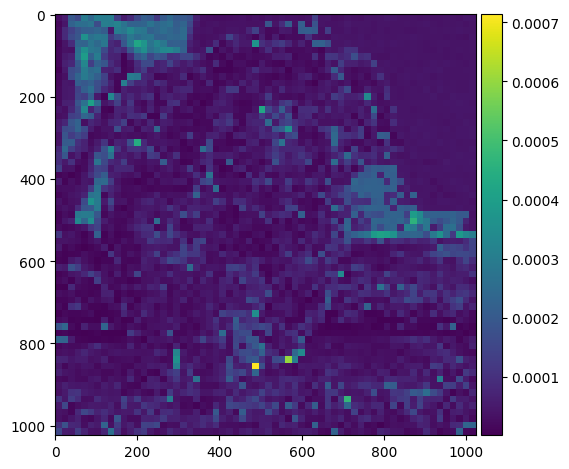

torch.Size([1, 1, 1024, 1024])


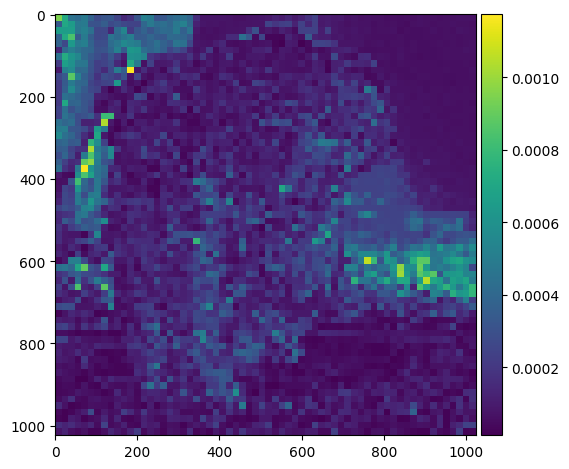

In [14]:
num_heads = attentions.shape[1]

for attention_head in range(num_heads):
    attentions_map = attentions[:,attention_head,:,0]
    attentions_map = attentions_map[:,1:] ## removing cls token ## [1,num_patches]
    map_size = int(np.sqrt(4096))

    attentions_map = attentions_map.view(1,1,map_size,map_size) ## adding channel axis for upsample

    attentions_map = nn.Upsample(size=(1024,1024))(attentions_map)
    print(attentions_map.shape)

    attentions_map = attentions_map[0,0,:,:].detach().cpu().numpy()

#     attentions_map = (attentions_map-attentions_map.min())/(attentions_map.max()-attentions_map.min())
    io.imshow(attentions_map)
    plt.show()
    

## Visualizing Attentions Vector Outputs patchwise based on mean of all heads

In [22]:
attentions = output["attentions"][-1] ## 1xnum_patches+1x768
print(attentions.shape)

torch.Size([1, 12, 4097, 4097])


torch.Size([1, 1, 1024, 1024])


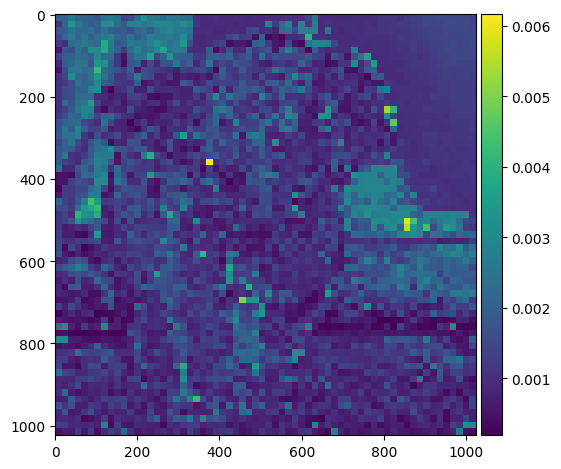

In [23]:
attentions_map = attentions.sum(axis=1)
attentions_map = attentions_map[:,:,0]
attentions_map = attentions_map[:,1:] ## removing cls token ## [1,num_patches]
map_size = int(np.sqrt(4096))

attentions_map = attentions_map.view(1,1,map_size,map_size) ## adding channel axis for upsample

attentions_map = nn.Upsample(size=(1024,1024))(attentions_map)
print(attentions_map.shape)

attentions_map = attentions_map[0,0,:,:].detach().cpu().numpy()

#     attentions_map = (attentions_map-attentions_map.min())/(attentions_map.max()-attentions_map.min())
io.imshow(attentions_map)
plt.show()